### Setup and check gpu availability

In [71]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import PIL.Image as Image

from tensorflow.keras import layers

tf.test.is_gpu_available()


True

### Download flowers dataset

In [72]:
data_root = tf.keras.utils.get_file(
    'flower_photos', 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

In [73]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root),
                                                 target_size=(224,224))

Found 3670 images belonging to 5 classes.


### Download the headless classifier

Use the [MobileNet V2 architecture](https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4) implemented on [tensorflow hub](tfhub.dev).

In [74]:
feature_extractor_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [75]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                        input_shape=(224,224,3))

### Attach a classification head
Freeze the feature extractor layer to complete the model

In [76]:
feature_extractor_layer.trainable = False

model=tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_4 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


### Train the model

Compile, then fit the model

In [77]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['acc'])

Simple callback to get loss and accuracy after every batch trained

In [78]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []
        
    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()

Fit the model

In [79]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit(image_data, epochs=2,
                    steps_per_epoch=steps_per_epoch,
                   callbacks=[batch_stats_callback])

Epoch 1/2
115/115 [==============================] - 24s 212ms/step - loss: 0.7157 - acc: 0.8438
Epoch 2/2
115/115 [==============================] - 23s 204ms/step - loss: 0.3507 - acc: 0.8438


### Some visualization
Plots for losses, accuracy, and some samples 

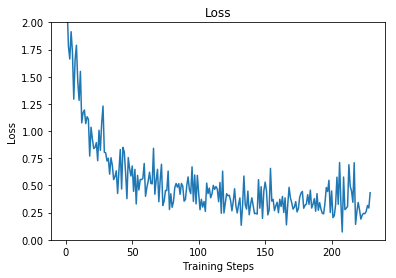

In [80]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.title("Loss")
_ = plt.plot(batch_stats_callback.batch_losses)

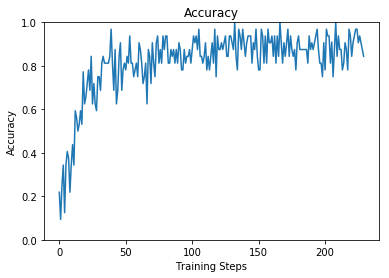

In [81]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.title("Accuracy")
_ = plt.plot(batch_stats_callback.batch_acc)

In [82]:
class_names = image_data.class_indices.items()
class_names = np.array([a for a, b in class_names])
class_names

array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

In [83]:
for image_batch, label_batch in image_data:
    break

In [84]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
label_id = np.argmax(label_batch, axis=-1)

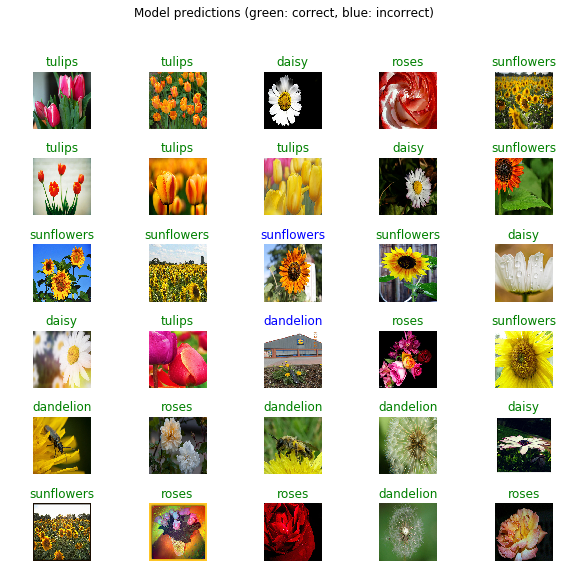

In [86]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    color = "green" if predicted_id[n] == label_id[n] else "blue"
    plt.title(str(class_names[label_id[n]]), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, blue: incorrect)")